# Report

# Setup

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

seed = 42
pal = sns.color_palette('Spectral', 10) # Set palette

In [42]:
df = pd.read_csv('recipe_site_traffic_2212.csv')

# Data Validation

## Quick Overview
First we take a quick look at the data using `head()` and `info()`.

In [43]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


We see that "servings" has object type, when it should be int.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


## Servings column
Using `value_counts()` we see the problem comes from the fact that there are rows called "4 as a snack" and "6 as a snack". The data from these rows is turned into "4" and "6", and we turn the entire column to int type.

In [45]:
# Check "servings"
df['servings'].value_counts()

4               389
6               197
2               183
1               175
4 as a snack      2
6 as a snack      1
Name: servings, dtype: int64

In [46]:
# Fixing "servings"
df['servings'].replace({'4 as a snack':'4'}, inplace = True)
df['servings'].replace({'6 as a snack':'6'}, inplace = True)
df['servings'] = df['servings'].astype(int)
df['servings'].value_counts()

4    391
6    198
2    183
1    175
Name: servings, dtype: int64

## Categories column
There is an extra category, called "Chicken Breast". This should clearly be "Chicken", so we replace these values.

In [47]:
# Check "categories"
df['category'].value_counts()

Breakfast         106
Chicken Breast     98
Beverages          92
Lunch/Snacks       89
Potato             88
Pork               84
Vegetable          83
Dessert            83
Meat               79
Chicken            74
One Dish Meal      71
Name: category, dtype: int64

In [48]:
# Fix "categories"
df['category'].replace('Chicken Breast','Chicken', inplace=True)

## Calories, Carbohydrate, Sugar and Protein columns
We ought to take a look at these float columns with `.describe()`. If there are negative values, values that are too high, or other discrepancies, this might shed light on them.

In [49]:
# Check "calories", "carbohydrate", "sugar", "protein"
df[['calories','carbohydrate','sugar','protein']].describe()

,calories,carbohydrate,sugar,protein
count,895.000000,895.000000,895.000000,895.000000
mean,435.939196,35.069676,9.046547,24.149296
std,453.020997,43.949032,14.679176,36.369739
min,0.140000,0.030000,0.010000,0.000000
25%,110.430000,8.375000,1.690000,3.195000
50%,288.550000,21.480000,4.550000,10.800000
75%,597.650000,44.965000,9.800000,30.200000
max,3633.160000,530.420000,148.750000,363.360000


## High Traffic column
For the data cleaning, it will be innapropriate to have null values as meaning "no high traffic". Null values should represent missing data only. Changed values to bool: "High" becomes True and null becomes False.

In [50]:
# Check "high_traffic"
df['high_traffic'].value_counts()

High    574
Name: high_traffic, dtype: int64

In [51]:
# Fix "high_traffic"
df['high_traffic'].replace('High', True, inplace=True)
df['high_traffic'].fillna(value=False, inplace=True)
df['high_traffic'].value_counts()

True     574
False    373
Name: high_traffic, dtype: int64

## Missing values
We see that there are 52 rows of simultaneously null "calories", "carbohydrate", "sugar", "protein" data, and no other missing values. Since these 52 rows account for only about 5% of the data, they are deleted.

In [52]:
# Check missing values
df.isna().sum()

recipe           0
calories        52
carbohydrate    52
sugar           52
protein         52
category         0
servings         0
high_traffic     0
dtype: int64

In [53]:
# Look at rows with missing values. We see they are the same
num_missing = len(df[df['calories'].isna() | df['carbohydrate'].isna() | df['sugar'].isna() | df['protein'].isna()])

In [54]:
perc_nan = 100*num_missing/len(df)
print("Percentage of missing values: {:.2f}%".format(perc_nan))
# The percentage is ~5% so we can delete this data no problem

Percentage of missing values: 5.49%


In [55]:
# Since we transformed high_traffic, we may now drop the null data
df = df.dropna()

# Exploratory Analysis

## Relationship between food category and traffic
Do some food categories perform better than others? To find out, we will count the percentage of high traffic recipes for each food category.

We see that the most popular recipes are Potato, Vegetable and Pork. The least popular are Chicken, Breakfast and, by far, Beverages. The rest lie in between.

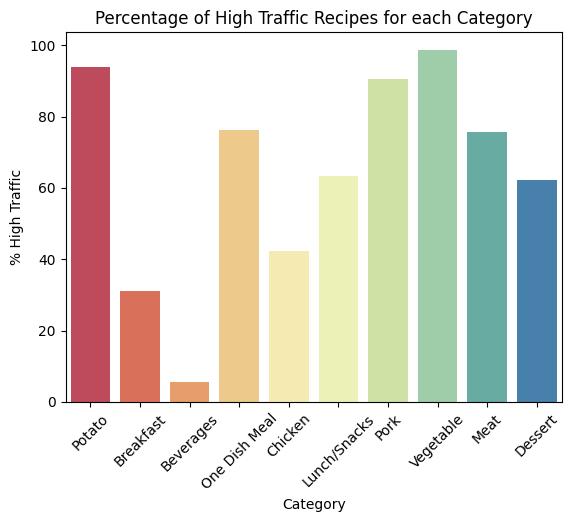

In [56]:
categories = df['category'].unique() # list of categories
percentages_dict = {} # dict of high traffic percentages for each category
for category in categories:
    df_category = df[df['category']==category]
    df_high_traffic = df_category[df_category['high_traffic']==True] 
    percentages_dict[category] = 100*len(df_high_traffic)/len(df_category)

sns.barplot(percentages_dict, palette=pal)
plt.xlabel('Category')
plt.ylabel('% High Traffic')
plt.title("Percentage of High Traffic Recipes for each Category")
plt.xticks(rotation=45)
plt.show()

## Count of recipes per category
The percentage of high traffic recipes for each food category is only as significant as the amount of data collected for each recipe. If there are few recipes for a certain category, its percentage of high traffic recipes will not mean much. Therefore, we need to count how many recipes there are for each category.

There's a good amount of recipes for each category (at least 60), so our previous results are probably accurate.

{'Potato': 83, 'Breakfast': 106, 'Beverages': 92, 'One Dish Meal': 67, 'Chicken': 163, 'Lunch/Snacks': 82, 'Pork': 73, 'Vegetable': 78, 'Meat': 74, 'Dessert': 77}


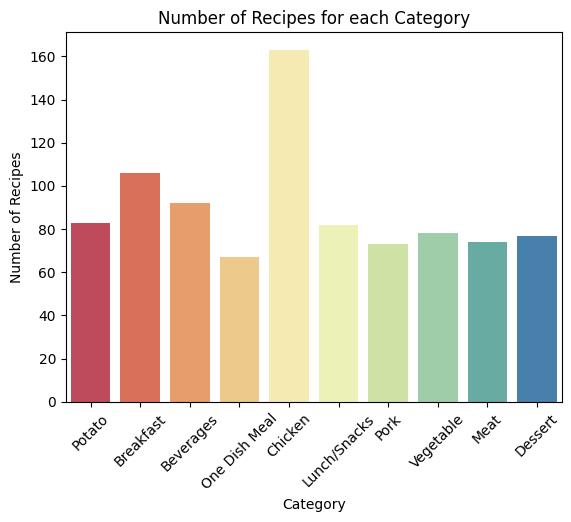

In [57]:
amount_of_recipes = {} # dict with recipe amount per food category
for category in categories:
    amount_of_recipes[category] = len(df[df['category']==category])

print(amount_of_recipes)
sns.barplot(amount_of_recipes, palette=pal)
plt.xlabel('Category')
plt.ylabel('Number of Recipes')
plt.title("Number of Recipes for each Category")
plt.xticks(rotation=45)
plt.show()

## Relationship between food category and calories
We know which categories are more popular. Let's check the mean calories per food category.

Beverages and Vegetables have the lowest calories. Meat, Pork, Chicken and One Dish Meals have relatively high calories. The rest of categories are in between.

In [58]:
servings = df.sort_values('servings',ascending=True)['servings'].unique() # list of servings

# Make a dictionary of dataframes, one for each serving amount
df_servings_dict = {}
for s in servings:
    df_servings_dict[s] = df[df['servings'] == s]

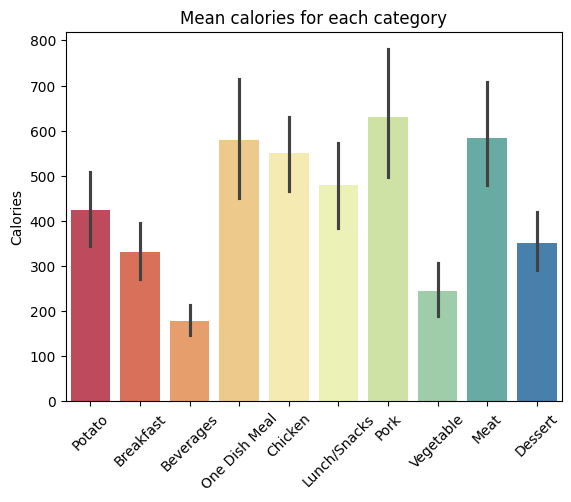

In [59]:
sns.barplot(data=df, x='category', y='calories', order=categories, palette=pal)
plt.xticks(rotation=45)
plt.xlabel("")
plt.ylabel("Calories")
plt.title("Mean calories for each category")
plt.show()

In [60]:
# fig, axes = plt.subplots(2,2, figsize=(12,10))
# k = 0
# for i in [0,1]:
#     for j in [0,1]:
#         s = servings[k]
#         k += 1
#         sns.barplot(data=df_servings_dict[s],
#                     x='category',
#                     y='calories',
#                     ax=axes[i,j],
#                     order=categories,
#                     palette=pal)
#         axes[i,j].set_xlabel("")
#         axes[i,j].set_ylabel("Calories")
#         axes[i,j].set_title("{} Serving(s)".format(s))
#         axes[i,j].set_xticklabels(categories, rotation=45)
# plt.suptitle("Mean calories per food category, per servings")
# plt.subplots_adjust(hspace=0.6)
# plt.show()

## Distribution of calories
We know the mean calories per food category, but how are the calories distributed through all the recipes? It appears that the number of recipes gets exponentially lower the higher the calories are.

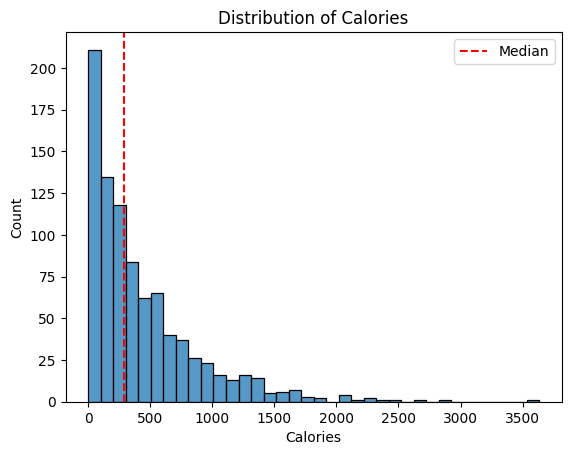

In [61]:
median = df['calories'].median()
mean   = df['calories'].mean()
sns.histplot(data=df, x='calories')
plt.axvline(x=median, linestyle='--', color='red', label='Median')
plt.xlabel('Calories')
plt.legend()
plt.title('Distribution of Calories')
plt.show()

## Correlation
Let's check the correlation between our variables. There is a slight correlation between category and sugar (0.26), between high traffic and category (0.22), and between protein and calories (0.17). The other variables have no significant correlation.

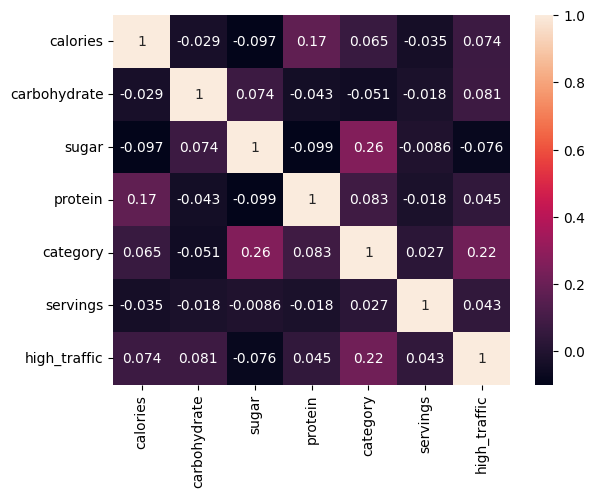

In [62]:
# We need to numerically encode the categories to check for correlation using a heatmap
cat_numbers = {}
for i in range(len(categories)):
    cat_numbers[categories[i]] = i

df_encoded = df.replace({'category':cat_numbers, 'high_traffic':{True:1, False:0}})

sns.heatmap(df_encoded[['calories','carbohydrate','sugar','protein','category','servings','high_traffic']].corr(), annot=True)
plt.show()

# Model Development
This is clearly a supervised classification problem, because we want to classify data as "high" or "low" traffic, a variable that we use to train the model.

In [63]:
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

Since category is a column of strings, one-hot encoding is necessary.

In [64]:
# one-hot encoding for categories
cat_dummies = pd.get_dummies(df['category'])
df_dummies = pd.concat([df, cat_dummies], axis=1)

Index(['recipe', 'calories', 'carbohydrate', 'sugar', 'protein', 'category',
       'servings', 'high_traffic', 'Beverages', 'Breakfast', 'Chicken',
       'Dessert', 'Lunch/Snacks', 'Meat', 'One Dish Meal', 'Pork', 'Potato',
       'Vegetable'],
      dtype='object')


## Train-test split
- The features are calories, carbohydrate, sugar, protein, servings and category.
- The target variable is "high traffic".

In [65]:
# Target, feature, train-test split
X = df_dummies[['calories','carbohydrate','sugar','protein','servings','Beverages','Breakfast','Chicken','Dessert','Lunch/Snacks','Meat','One Dish Meal','Pork','Potato','Vegetable']]
y = df_dummies['high_traffic']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=seed)

In [66]:
# Standardising
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Baseline Model
The baseline model was sklearn's DummyClassifier, with strategy="most_frequent". This simply picks the most frequent class label in y to make predictions.

In [67]:
# Baseline model
baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train_scaled, y_train)
baseline_pred = baseline.predict(X_test_scaled)

## Random Forests with Grid Search CV
The comparison model was sklearn's Random Forests. This choice was made not only because of the model's performance but also because it allows us to see feature importance and thus better feature selection.

The model was refined using Grid Search Cross Validation. Since this process takes about 10 minutes of computation on a good computer, a variable `gridsearch_rf = False` was set - the grid search is only performed if this is set to `True`. The best result was already collected and stored in the variable `rf_best`.

In [68]:
# Grid-Search CV for RF
gridsearch_rf = False
if gridsearch_rf == True:
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    param_grid = {
        'n_estimators': [50, 100, 200],  # Number of trees in the forest
        'criterion': ['gini', 'entropy'],  # Splitting criterion
        'max_depth': [None, 10, 20, 30],  # Maximum depth of the trees
        'min_samples_split': [2, 5, 10],  # Minimum samples required to split an internal node
        'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
        'max_features': ['auto', 'sqrt', 'log2'],  # Number of features to consider for the best split
        'bootstrap': [True, False]  # Whether samples are drawn with replacement
    }

    rf = RandomForestClassifier(random_state=seed)
    rf_cv = GridSearchCV(rf, param_grid, cv=kf)
    rf_cv_result = rf_cv.fit(X_train_scaled, y_train)
    y_pred = rf_cv_result.predict(X_test_scaled)
    print("Best RF:", rf_cv_result.best_estimator_)
    print("Best RF Score: {:.3f}".format(accuracy_score(y_test, y_pred)))

In [69]:
rf_best = RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                       max_features='auto', min_samples_leaf=2,
                       min_samples_split=10, random_state=42)

rf_best.fit(X_train_scaled, y_train)
rf_pred = rf_best.predict(X_test_scaled)

# Model Evaluation
Let's see how the baseline and Random Forests models compare. As per the email, the task given was to _"predict which recipes will be popular 80% of the time and minimize the chance of showing unpopular recipes."_ Because of the emphasis in minimising the chance of showing unpopular recipes - which in this context are false positives - **precision** was chosen as an appropriate metric. Thus we want a precision of 80% or higher.

## Baseline Model Performance
The baseline model had a precision of 60%, which does not represent any improvement to the business' current strategy.

In [70]:
print("Classification Report for Baseline Model:")
print(classification_report(y_test, baseline_pred))

Classification Report for Baseline Model:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00        90
        True       0.60      1.00      0.75       134

    accuracy                           0.60       224
   macro avg       0.30      0.50      0.37       224
weighted avg       0.36      0.60      0.45       224



## Comparison Model Performance
The Random Forests model had a precision of 83%, which is a significant improvement.
The feature importance supports our previous findings: categories that have a very high (Vegetable, Potato) or very low (Beverages, Breakfast) percentage of high traffic have great traffic prediction power, while recipes with average performance (Chicken, Meat, Lunch/Snacks, One Dish Meal, Dessert) are more ambiguous and thus have less feature importance. It seems only Pork somewhat breaks this tendency.

In [71]:
print("Classification Report for Random Forests:")
print(classification_report(y_test, rf_pred))

Classification Report for Random Forests:
              precision    recall  f1-score   support

       False       0.70      0.77      0.73        90
        True       0.83      0.78      0.80       134

    accuracy                           0.77       224
   macro avg       0.76      0.77      0.77       224
weighted avg       0.78      0.77      0.77       224



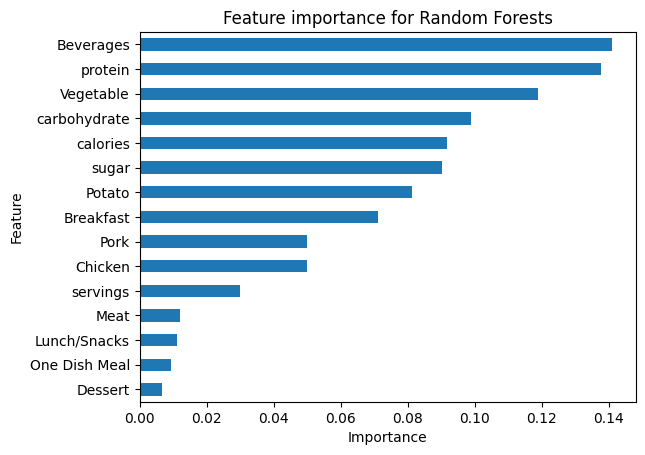

In [72]:
# Feature importance
importances_rf = pd.Series(rf_best.feature_importances_, index = X.columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf.plot(kind='barh')
plt.title("Feature importance for Random Forests")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# Business Metrics
- A good **performance indicator**, at least with the data available, is the **percentage of high traffic recipes, out of all recipes**.
- The business **currently has a 60% proportion** of High Traffic to Low Traffic recipes. The model provided can increase that to around **80%.**
- Another approach would be to think in terms of the number of recipe views itself, and turn this into a Regression problem, though this would require an entirely new analysis.

In [74]:
# Percentage of high traffic recipes
perc_high = 100*len(df[df['high_traffic']==True])/len(df)
print("Current Percentage of High Traffic recipes: {:.1f}%".format(perc_high))

Current Percentage of High Traffic recipes: 59.8%


# Final Recommendations
- The business should keep tracking page views for recipes and assign an appropriate view count to assess if the recipe is High Traffic or Low Traffic, as they have been doing.
- The business should split its users into a test group (A), for whom the recipes shown are according to the model provided, and a control group (B), for whom the recipes shown should follow the same protocol they have thus far.
- Continue to measure the proportion of successful, high traffic recipes, for each group.
- If this experiment is successful, the business should fully implement the model for its entire market and seek to refine it with machine learning engineers.